# Generalized prolate spheroidal sequences

The goal here is to produce the Bronez spectral estimator for unequal time spacing, see Table 1 of [Bronez, 1988](https://ieeexplore.ieee.org/abstract/document/9031). To compute the tapers, one can use equations (21)-(23) in [Chave, 2019](https://academic.oup.com/gji/article-abstract/218/3/2165/5519233) and looking at Fig. 19, we find frequency-dependent tapers that can take complex values. 

First, some utility code.

In [2]:
using Plots, LombScargle, NFFT, Multitaper

## Recreate Fig 20 from Chave, 2019

This is an interesting nonuniform temporal grid for illustration purposes - the $\Delta t$ is in sorted order.

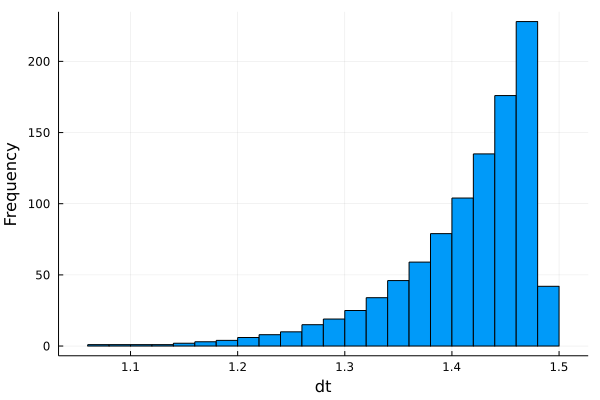

In [3]:
t = collect(1:1000).^(1.05)
w = 0.008
K = 5

histogram(diff(t),legend=false,xlabel="dt",ylabel="Frequency")

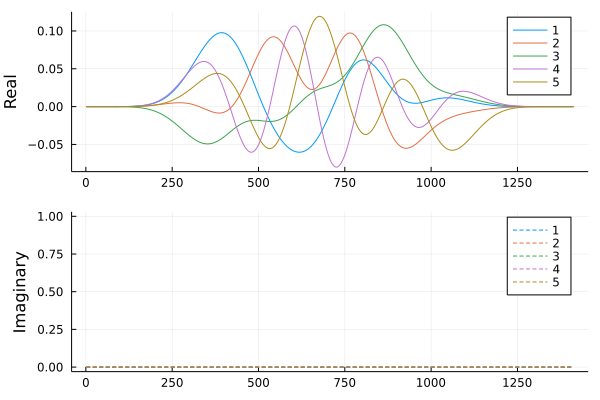

In [4]:
lamc, slepsc, cho = gpss(w, K, t, 0.0)
size(slepsc)

p1 = plot(t,real.(slepsc), ylabel= "Real", label=collect(1:5)',legend=:topright)
p2 = plot(t,imag.(slepsc), ylabel= "Imaginary", label=collect(1:5)',legend=:topright,linestyle=:dash)
p = plot(p1,p2,layout = (2,1))

In [5]:
# Checking orthogonality
(cho.L*slepsc)'*cho.L*slepsc

5×5 Array{Complex{Float64},2}:
     1.00001+0.0im  -1.88612e-7+0.0im  …   1.30492e-6+0.0im
 -1.88612e-7+0.0im      1.00001+0.0im     -3.13822e-7+0.0im
  -2.0103e-6+0.0im  -1.04525e-8+0.0im     -5.54947e-7+0.0im
   8.9515e-7+0.0im   2.65515e-8+0.0im      9.78497e-7+0.0im
  1.30492e-6+0.0im  -3.13822e-7+0.0im         1.00001+0.0im

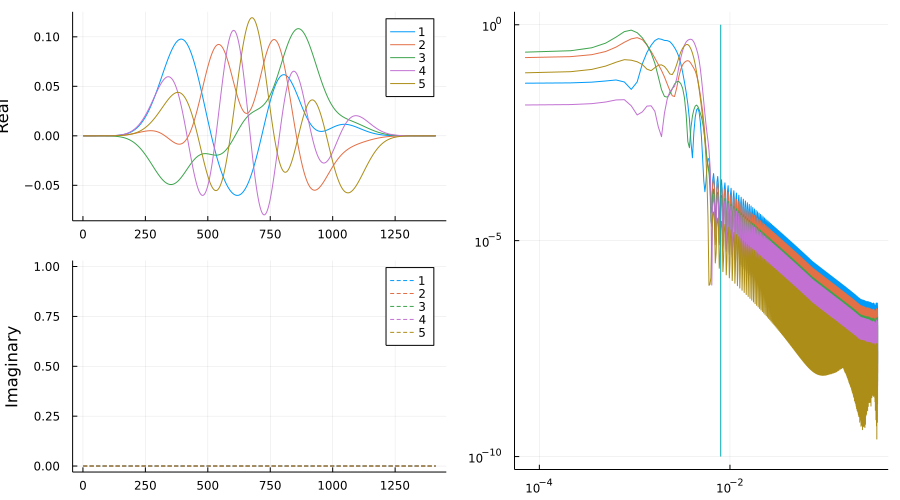

In [6]:
# Since this guy is real:
# Get a Lomb-Scargle periodogram of the dataset multiplied by a taper

function getpow(t, y, taper, nyq)
    plan = LombScargle.plan(t, taper .* y, nyquist_factor=nyq)
    pgram = lombscargle(plan)
    freq, pow = freqpower(pgram)
    return freq, pow
end

spectrumvec = Float64[]
for i in 1:K
    freq, poww = getpow(t, ones(length(t)), real.(slepsc[:,i]), 2)
    append!(spectrumvec, poww)
    if i == 1; freq = freq; end
end
spectrum_estimates = reshape(spectrumvec, :, K)

# Get the frequency grid
planls = LombScargle.plan(t, ones(length(t)), nyquist_factor=2)
pgramls = lombscargle(planls)
freq1s = freqpower(pgramls)[1]

p3 = plot(freq1s[1:2500], spectrum_estimates[1:2500,:], xscale=:log10, yscale=:log10, 
    #title = "Unequally-spaced Slepians at frequency 0.0",
    legend=:false)
plot!(p3,w*[1,1],[1e-10,1e0])
plot(p,p3,layout=(1,2),size=(900,500))


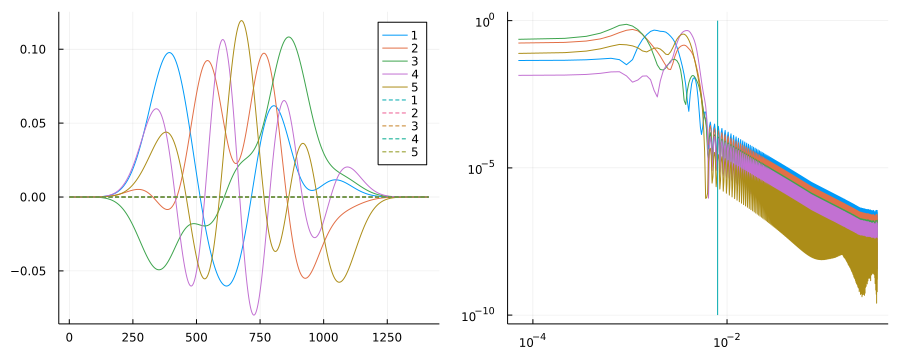

In [7]:
p1 = plot(t,real.(slepsc), label=collect(1:5)',legend=:topright)
plot!(p1,t,imag.(slepsc), label=collect(1:5)',legend=:topright,linestyle=:dash)
p = plot(p1,p3,layout=(1,2),size=(900,350))

# Now we go in and produce an NFFT based estimate of the power

In [10]:
M = size(slepsc,1)
freq = LinRange(-0.5,0.5,1024)
N = length(freq)

plan = NFFTPlan(freq, M)
f = mapslices(x->abs2.(nfft(plan, x)), slepsc, dims=1);

As promised, we get excellent concentration properties.

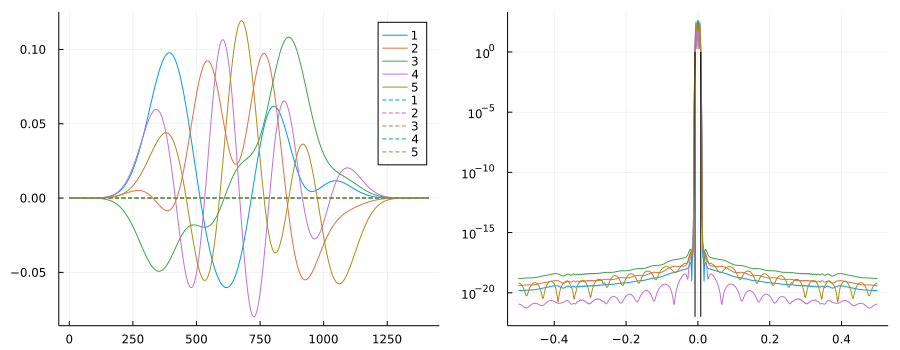

In [13]:
pa = plot(freq, f, yscale=:log10,legend=false)
plot!(pa, w*[1,1], [1e-22,1e1], c = :black)
plot!(pa, -w*[1,1], [1e-22,1e1], c = :black)
pq = plot(p1,pa,layout=(1,2),size=(900,350))

Finally, to enhance the look of the bandwidth choice, plot the frequency scale on a symmetric log-log plot (two axes split, one reversed, and omitting zero).

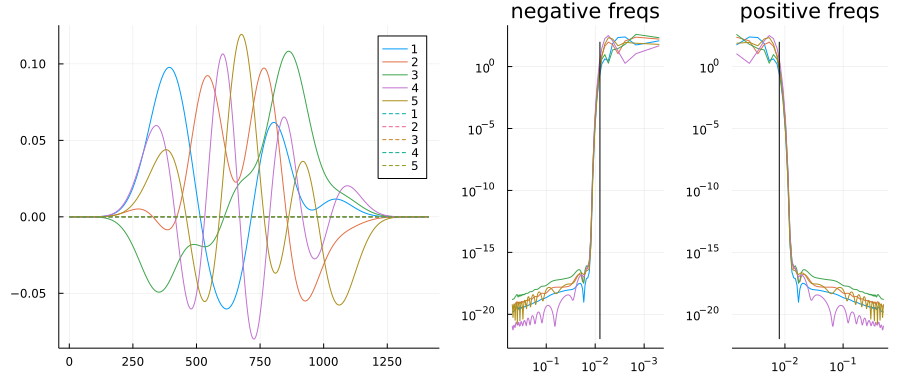

In [18]:
poshalf = Int64(round(N/2+2)):N
neghalf = 1:Int64(round(N/2))
p1a = plot(-freq[neghalf], f[neghalf,:],title="negative freqs",
    yscale=:log10,xscale = :log10, xaxis=:flip,legend=false)
plot!(p1a, w*[1,1], [1e-22,1e2], c = :black)
p2 = plot(freq[poshalf],f[poshalf,:],yaxis=:false,title="positive freqs",
    yscale=:log10,xscale = :log10,legend=false) #,yaxis.guide_position=:right)
plot!(p2, w*[1,1], [1e-22,1e2], c = :black)
qp = plot(p1a,p2,layout=(1,2))

pqq = plot(p1,qp,layout=(1,2),size=(900,375))

Try another frequency, this time one that will give a complex taper.

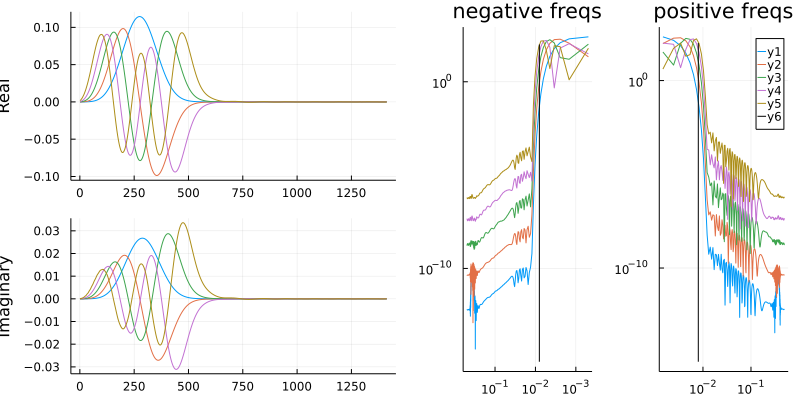

In [20]:
lamc, slepsc, cho = Multitaper.gpss(w, K, t, 0.2)
size(slepsc)

p1 = plot(t,real.(slepsc), ylabel= "Real", label=collect(1:5)',legend=false)
p2 = plot(t,imag.(slepsc), ylabel= "Imaginary", label=collect(1:5)',legend=false)
pq = plot(p1,p2,layout = (2,1))

f = mapslices(x->abs2.(nfft(plan, x)), slepsc, dims=1)

p3 = plot(-freq[neghalf], f[neghalf,:],
    yscale=:log10,xscale = :log10, xaxis=:flip,legend=false,
    title="negative freqs")
plot!(p3, w*[1,1], [1e-15,1e2], c = :black)
p4 = plot(freq[poshalf],f[poshalf,:],
    yscale=:log10,xscale = :log10,
    title="positive freqs") #,yaxis.guide_position=:right)
plot!(p4, w*[1,1], [1e-15,1e2], c = :black)
pp = plot(p3,p4,layout=(1,2))

plot(pq,pp,layout=(1,2),size=(800,400))

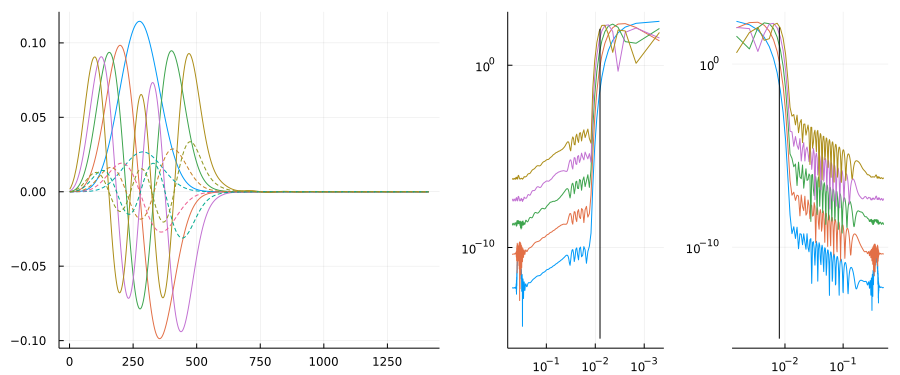

In [21]:
p1 = plot(t,real.(slepsc), label=collect(1:5)',legend=false)
plot!(p1,t,imag.(slepsc), label=collect(1:5)',legend=false,linestyle=:dash)

p3 = plot(-freq[neghalf], f[neghalf,:],
    yscale=:log10,xscale = :log10, xaxis=:flip,legend=false)
plot!(p3, w*[1,1], [1e-15,1e2], c = :black)
p4 = plot(freq[poshalf],f[poshalf,:], legend=false,
    yscale=:log10,xscale = :log10,yaxis=false) #,yaxis.guide_position=:right)
plot!(p4, w*[1,1], [1e-15,1e2], c = :black)
pp = plot(p3,p4,layout=(1,2))

q = plot(p1,pp,layout=(1,2),size=(900,375))

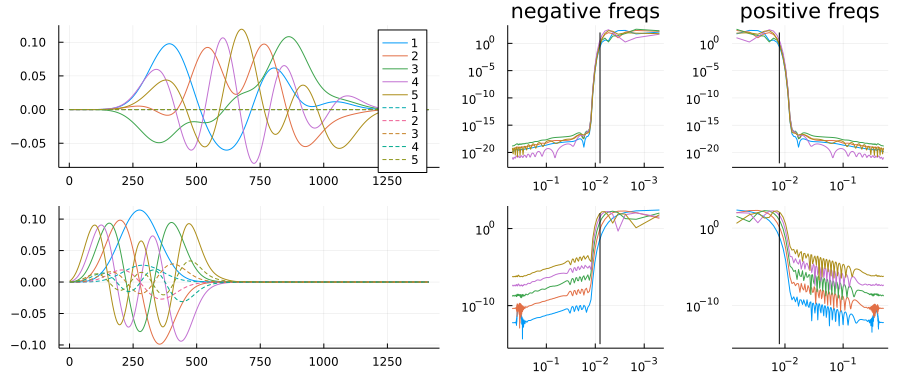

In [22]:
plot(pqq,q,layout=(2,1))
# savefig("gpss.png")